# Import libraries

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications.resnet import ResNet50 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomCrop, Resizing, Rescaling
from keras.callbacks import TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score

# Set configuration variables

In [ ]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
train_data_dir = 'dataset/train'
test_data_dir = 'dataset/test'


In [ ]:
img_width_before_resizing, img_height_before_resizing = 256, 256
img_width, img_height = 224, 224
batch_size = 32
epochs = 15 

## Configure callbacks

In [ ]:
logdir = os.path.join("logs", "resnet50")
tensorboard_callback = TensorBoard(log_dir=logdir)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5 
)

# Load datasets

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height_before_resizing, img_width_before_resizing),
  batch_size=batch_size)

Found 137 files belonging to 2 classes.
Using 110 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height_before_resizing, img_width_before_resizing),
  batch_size=batch_size)

Found 137 files belonging to 2 classes.
Using 27 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height_before_resizing, img_width_before_resizing),
  batch_size=batch_size
)

Found 31 files belonging to 2 classes.


## Print some samples

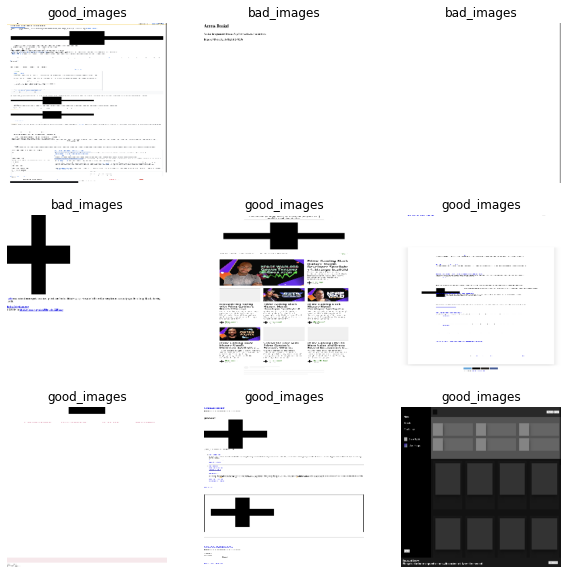

In [ ]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Define model

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add new classification layers
model = Sequential()
model.add(RandomCrop(img_height, img_width, seed=123))
model.add(Resizing(img_height, img_width))
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=epochs,
          callbacks=[tensorboard_callback, early_stopping_callback],
)

# Save the model and visualize training on tensorboard

In [ ]:
model.save("resnet50.h5")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir log

# Testing

In [ ]:
# NO TTA
loss, acc = model.evaluate(test_ds)

y_pred = model.predict(test_ds)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred).astype(int)

# Calculate accuracy and recall manually
y_true = labels 
recall = recall_score(y_true, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix with a plot
plt.imshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks([0, 1], train_ds.class_names)
plt.yticks([0, 1], train_ds.class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Print the evaluation metrics
print('Test Loss: {:.4f}'.format(loss))
print('Accuracy: {:.4f}'.format(acc))
print('Recall: {:.4f}'.format(recall))

## Use TTA

In [ ]:
# USING TTA

# Define TTA pipeline
tta_pipeline = Sequential()
tta_pipeline.add(RandomCrop(img_height, img_width, seed=123))
tta_pipeline.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

n_augmentations = 5 

# Create a function to apply TTA to your test data
def apply_tta(image):
    augmented_images = []
    for i in range(n_augmentations): # Apply augmentations
        augmented_image = tta_pipeline(image)
        augmented_images.append(augmented_image)
    return augmented_images

# Make predictions on augmented test data and average the results
predictions = []
for image, label in test_ds:
    augmented_images = apply_tta(image)
    batch_predictions = []
    for augmented_image in augmented_images:
        prediction = model.predict(augmented_image)
        batch_predictions.append(prediction)
    batch_predictions = tf.reduce_mean(batch_predictions, axis=0)
    predictions.append(batch_predictions)

# Compute the final predictions
predictions = tf.concat(predictions, axis=0)
final_predictions = tf.math.argmax(predictions, axis=1)

In [ ]:
# Compute accuracy
accuracy_metric = tf.metrics.Accuracy()
for image, label in test_ds:
    accuracy_metric.update_state(label, final_predictions)

accuracy = accuracy_metric.result().numpy()
print("TTA - Testing Accuracy: ", accuracy * 100)